CPH and ML 08/2022

# MOCCA data analysis of esterification reaction

MOCCA is a tool for the analysis of *High-Performance Liquid Chromatography–Diode Array Detection* (HPLC–DAD) datasets which are recorded in the context of reaction (process) controls. It only requires HPLC–DAD raw data and some basic user input for the data analysis. Within this specific script, we demonstrate how MOCCA can be used for the analysis of HPLC-DAD raw data stored in allotrope data format.

## Comment on esterification reaction
We performed a simple esterification reaction of benzoic acid with isopropanol under Steglich conditions and tracked the progress of the reaction via HPLC-DAD. The raw data were automatically exported as allotrope files (.ADF) and subsequently analyzed using MOCCA.


## Imports

In [1]:
# folders handling
import os
from glob import glob
from natsort import natsorted


# user interaction
from mocca.user_interaction.campaign import HplcDadCampaign
from mocca.user_interaction.user_objects import Gradient
from mocca.user_interaction.user_objects import Compound
from mocca.user_interaction.user_objects import InternalStandard
from mocca.user_interaction.user_objects import HplcInput
from mocca.user_interaction.settings import Settings

# reporting
from mocca.report.main import report

"""
#creation of separate reports
from mocca.report.hplc_input import report_hplc_input
from mocca.report.gradient import report_gradients
from mocca.report.chromatograms import report_chroms
from mocca.report.bad_chromatograms import report_bad_chroms
from mocca.report.compound_tracking import report_comp_tracking
from mocca.report.peak_library import report_peak_library
from mocca.report.compound_library import report_comp_library
from mocca.report.calibration_library import report_calib_library
from mocca.report.deconvolution import report_deconvolution
"""

%load_ext autoreload
%autoreload 2

### Folder handling

The data corresponding to this notebook can be found in mocca -> notebooks -> esterification_data. The data was recorded on an Agilent system with an automatic export of the raw data as .ADF file.

In [2]:
# get path of this notebook
ipynb_path = os.path.dirname(os.path.realpath("__file__"))

# add the path to the test data folder
data_path = os.path.join(ipynb_path, "esterification_data")

# find .ADF files
folders = natsorted(glob(data_path + '/*' + '.ADF'))


In [3]:
for folder in folders:
    print(os.path.basename(folder))

SiSa_20220512blank2.ADF
SiSa_$Sample_1_2022-05-12 20-07-27+02-00 [5]_12_05_2022 19_42_30.ADF
SiSa_$Sample_2_2022-05-12 20-41-29+02-00 [5]_12_05_2022 19_42_30.ADF
SiSa_$Sample_3_2022-05-12 21-50-31+02-00 [5]_12_05_2022 19_42_30.ADF
SiSa_$Sample_4_2022-05-12 23-59-36+02-00 [5]_12_05_2022 19_42_30.ADF
SiSa_$Sample_5_2022-05-13 01-38-40+02-00 [5]_12_05_2022 19_42_30.ADF
SiSa_$Sample_6_2022-05-13 03-17-43+02-00 [5]_12_05_2022 19_42_30.ADF
SiSa_$Sample_7_2022-05-13 04-56-47+02-00 [5]_12_05_2022 19_42_30.ADF
SiSa_$Sample_8_2022-05-13 07-05-52+02-00 [5]_12_05_2022 19_42_31.ADF
SiSa_$Sample_9_2022-05-13 09-14-57+02-00 [5]_12_05_2022 19_42_31.ADF
SiSa_$Sample_10_2022-05-13 11-24-01+02-00 [5]_12_05_2022 19_42_31.ADF
SiSa_$Sample_11_2022-05-13 15-25-52+02-00 [5]_12_05_2022 19_42_31.ADF
SiSa_blank1_2022-05-23 10-39-12+02-00-02.ADF
SiSa_istd_ditertbutylbiphenyl-20220518 092221.ADF
SiSa_product_bzoipr_diluted.ADF


### Campaign initialization and user input

In [4]:
esterification_campaign = HplcDadCampaign()

The first gradient run was recorded for the baseline correction of the two compound inputs, the second gradient run for the baseline correction of the reaction runs.

In [5]:
gradient_ref = Gradient(next(folder for folder in folders if "blank1" in folder))
gradient_rxn = Gradient(next(folder for folder in folders if "blank2" in folder))

We create Hplc input objects for the internal standard, 4,4'-di-tert-butylbiphenyl, and the product (BzOiPr) and add them to the campaign. Note that we add the internal standard as a regular compound (not as an internal standard) here. We will calculate the relative signal intensities by ourselves later.

In [6]:
istd_folder = next(folder for folder in folders if "istd" in folder)
product_folder = next(folder for folder in folders if "product" in folder)

init_istd = HplcInput(istd_folder, gradient_ref, Compound('istd'))
init_product = HplcInput(product_folder, gradient_ref, Compound('BzOiPr'))

esterification_campaign.add_hplc_input(init_istd)
esterification_campaign.add_hplc_input(init_product)

### User input for reaction runs
We create HplcInput objects for each reaction run and add them to the campaign.

In [7]:
for folder in [folder for folder in folders if "Sample" in folder]:
    exp = HplcInput(folder, gradient_rxn)
    esterification_campaign.add_hplc_input(exp)

### Settings for data processing

In [8]:
settings = Settings('allotrope',
                    absorbance_threshold = 500, wl_high_pass = 210, wl_low_pass = 300,
                    peaks_high_pass = 3, peaks_low_pass = 13,
                    spectrum_correl_thresh=0.99, relative_distance_thresh=0.01)

### Data processing
Note that the product peak overlaps with the peak of an intermediate and the deconvolution algorithm is triggered for every reaction run leading to comparably long processing times.

In [9]:
%%time
esterification_campaign.process_all_hplc_input(settings)

CPU times: total: 1h 16min 21s
Wall time: 20min 9s


Save campaign as .pkl-file

In [10]:
#the campaign is saved within the notebook folder or alternatively to a given path
esterification_campaign.save_campaign('esterification_campaign.pkl', remove_raw_data=False)

Load campaign from .pkl-file

In [14]:
esterification_campaign.load_campaign('esterification_campaign.pkl')

### Reporting

In [11]:
#directory at which reports are saved
report_path = os.path.join(ipynb_path, "esterification reports")

In [12]:
report(esterification_campaign, report_path)

Report saved to ./C:\Users\GMJAZ\OneDrive - Bayer\Personal Data\GitHub\mocca\notebooks\esterification reports\hplc_input.html. To upload and share your report, create a free Datapane account by running `!datapane signup`.

Report saved to ./C:\Users\GMJAZ\OneDrive - Bayer\Personal Data\GitHub\mocca\notebooks\esterification reports\gradient.html. To upload and share your report, create a free Datapane account by running `!datapane signup`.

How is your experience of Datapane? Please take two minutes to answer our anonymous product survey <a href='https://bit.ly/3lWjRlr' target='_blank'>here</a>

Report saved to ./C:\Users\GMJAZ\OneDrive - Bayer\Personal Data\GitHub\mocca\notebooks\esterification reports\peak_library.html. To upload and share your report, create a free Datapane account by running `!datapane signup`.

error uploading: HTTPSConnectionPool(host='events.datapane.com', port=443): Max retries exceeded with url: /batch/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:997)')))
error uploading: HTTPSConnectionPool(host='events.datapane.com', port=443): Max retries exceeded with url: /batch/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:997)')))


Report saved to ./C:\Users\GMJAZ\OneDrive - Bayer\Personal Data\GitHub\mocca\notebooks\esterification reports\chromatograms.html. To upload and share your report, create a free Datapane account by running `!datapane signup`.

How is your experience of Datapane? Please take two minutes to answer our anonymous product survey <a href='https://bit.ly/3lWjRlr' target='_blank'>here</a>

No chromatograms given or all chromatograms are good data!


Report saved to ./C:\Users\GMJAZ\OneDrive - Bayer\Personal Data\GitHub\mocca\notebooks\esterification reports\compound_tracking.html. To upload and share your report, create a free Datapane account by running `!datapane signup`.

error uploading: HTTPSConnectionPool(host='events.datapane.com', port=443): Max retries exceeded with url: /batch/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:997)')))
error uploading: HTTPSConnectionPool(host='events.datapane.com', port=443): Max retries exceeded with url: /batch/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:997)')))


Report saved to ./C:\Users\GMJAZ\OneDrive - Bayer\Personal Data\GitHub\mocca\notebooks\esterification reports\deconvolution.html. To upload and share your report, create a free Datapane account by running `!datapane signup`.

How is your experience of Datapane? Please take two minutes to answer our anonymous product survey <a href='https://bit.ly/3lWjRlr' target='_blank'>here</a>

Report saved to ./C:\Users\GMJAZ\OneDrive - Bayer\Personal Data\GitHub\mocca\notebooks\esterification reports\compound_library.html. To upload and share your report, create a free Datapane account by running `!datapane signup`.

No components in the quantitative component database!


### Customized data analysis

This data analysis tool cannot include all possible data analysis needs of potential users. Therefore, we expect the user to do customized data analysis independently of the tool's reporting function.

As an example, we show how the integrals of compounds of interest can be extracted from the MOCCA campaign and plotted.

In [13]:
import pandas as pd
import datetime
import time
import matplotlib.pyplot as plt


We extract the results out of the campaign object and create a dataframe that contains all relevant information.

In [14]:
#create dictionary with relevant results by extracting data from campaign objects
results = {
    'BzOiPr': [],
    'unknown_1': [],
    'unknown_2': [],
    'unknown_3': [],
    'unknown_4': [],
    'istd': [],
    'rel_product_area': [],
    'path': []
    }

for i, chrom in enumerate(esterification_campaign.chroms):
    if not chrom.experiment.compound:
        results['BzOiPr'].append(0)
        results['unknown_1'].append(0)
        results['unknown_2'].append(0)
        results['unknown_3'].append(0)
        results['unknown_4'].append(0)
        results['istd'].append(0)
        results['rel_product_area'].append(0)
        results['path'].append(chrom.experiment.path)
        for peak in chrom.peaks:
            if peak.compound_id == 'BzOiPr':
                results['BzOiPr'][-1] = peak.integral
            if peak.compound_id == 'unknown_1':
                results['unknown_1'][-1] = peak.integral
            if peak.compound_id == 'unknown_2':
                results['unknown_2'][-1] = peak.integral
            if peak.compound_id == 'unknown_3':
                results['unknown_3'][-1] = peak.integral
            if peak.compound_id == 'unknown_4':
                results['unknown_4'][-1] = peak.integral    
            if peak.compound_id == 'istd':
                results['istd'][-1] = peak.integral
                results['rel_product_area'][-1] = results['BzOiPr'][-1] / peak.integral

In [15]:
results_df = pd.DataFrame(results)

The HPLC samples were prepared and directly injected automatically. Therefore, we can extract our time point values from the data files' time stamps.

In [16]:
#The time stamp is extracted from the file name and converted into datetime format. The reaction time are then calculated as the time difference between the respective sample and the first sample.
time_list = []
rxntime_list = []
for element in folders[1:12]:
    date = element.split("_")[4][0:19]
    time_format = datetime.datetime.strptime(date, '%Y-%m-%d %H-%M-%S')
    time_list.append(time_format)
    time_diff = time_format - time_list[0]
    time_hrs = time_diff.total_seconds() /3600
    rxntime_list.append(time_hrs)
results_df['rxn_times'] = rxntime_list
results_df


error uploading: HTTPSConnectionPool(host='events.datapane.com', port=443): Max retries exceeded with url: /batch/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:997)')))


,BzOiPr,unknown_1,unknown_2,unknown_3,unknown_4,istd,rel_product_area,path,rxn_times
0,0.000000,145605.111421,12318.065491,470626.198356,46552.822253,253730.488165,0.000000,C:\Users\GMJAZ\OneDrive - Bayer\Personal Data\...,0.000000
1,61421.971623,118654.755289,12149.296185,476072.773468,55095.569486,216348.176594,0.283903,C:\Users\GMJAZ\OneDrive - Bayer\Personal Data\...,0.567222
2,155210.270490,110041.876103,13506.317329,349319.956282,71703.745405,211720.258945,0.733091,C:\Users\GMJAZ\OneDrive - Bayer\Personal Data\...,1.717778
3,259586.565674,100893.037397,12847.311951,203251.735180,88746.370789,216426.532925,1.199421,C:\Users\GMJAZ\OneDrive - Bayer\Personal Data\...,3.869167
4,308498.026960,96968.952491,13368.102938,145142.593180,101085.199243,219213.039018,1.407298,C:\Users\GMJAZ\OneDrive - Bayer\Personal Data\...,5.520278
5,343297.699964,91093.744402,13018.116301,101767.394469,108428.777191,220673.498693,1.555682,C:\Users\GMJAZ\OneDrive - Bayer\Personal Data\...,7.171111
6,371831.938209,85601.205926,12497.008355,68798.563568,115172.938385,220114.605448,1.689265,C:\Users\GMJAZ\OneDrive - Bayer\Personal Data\...,8.822222
7,393830.575894,83517.672478,12695.658544,42545.861861,122696.560218,222005.119793,1.773971,C:\Users\GMJAZ\OneDrive - Bayer\Personal Data\...,10.973611
8,415971.597578,79852.100295,12380.231166,0.000000,128404.436250,227916.662542,1.825104,C:\Users\GMJAZ\OneDrive - Bayer\Personal Data\...,13.125000
9,438296.837102,74071.254813,12739.831581,0.000000,133345.335937,227671.423342,1.925129,C:\Users\GMJAZ\OneDrive - Bayer\Personal Data\...,15.276111


We can now plot the absolute and relative integral of our desired product versus time.

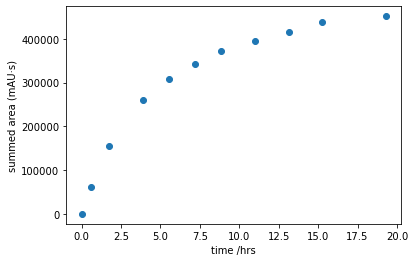

In [17]:
plt.clf()
plt.style.use('default')
ax = plt.scatter(x=results_df['rxn_times'], y = results_df['BzOiPr'])
plt.xlabel('time /hrs')
plt.ylabel('summed area (mAU·s)')
plt.show()
#plt.savefig(r'abs_prod_area_vs_time.png',bbox_inches='tight')

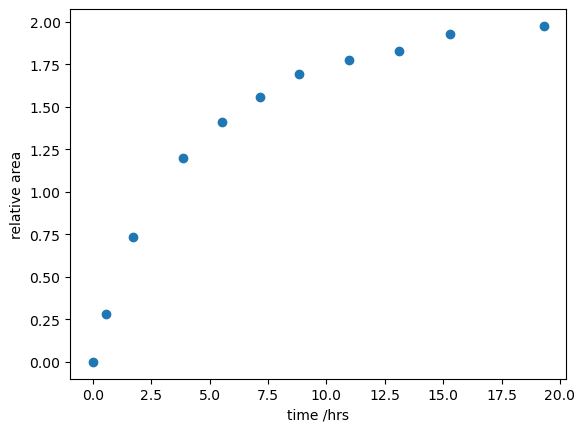

In [18]:
plt.clf()
plt.style.use('default')
ax = plt.scatter(x=results_df['rxn_times'], y = results_df['rel_product_area'])
plt.xlabel('time /hrs')
plt.ylabel('relative area')
plt.show()
#plt.savefig(r'rel_prod_area_vs_time.png',bbox_inches='tight')

An initially unknown intermediate was rapidly formed and was then consumed comparably slowly. MOCCA tracks previously unknown compounds over the reaction runs so that we can plot its intensity over time.

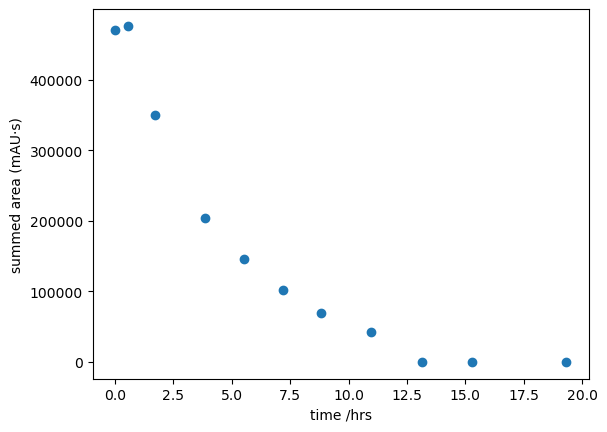

In [21]:
plt.clf()
plt.style.use('default')
ax = plt.scatter(x=results_df['rxn_times'], y = results_df['unknown_3'])
plt.xlabel('time /hrs')
plt.ylabel('summed area (mAU·s)')
plt.show()
#plt.savefig(r'esterification_unknown_3_intermediate.png',bbox_inches='tight')